In [1]:
MODEL_CHKPT = "/aul/homes/glucc002/Desktop/Projects/aura/aura/cnn/checkpoints/aura_emotion_classifier.pth"
STORAGE_PATH = "/disk/onyx-scratch/dullo009-fall2024/diamond/"

In [2]:
from aura.cnn import EmotionModel
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EmotionModel(pretrained=False).to(device)
model.load(MODEL_CHKPT)

/aul/homes/glucc002/miniconda3/envs/aura/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/aul/homes/glucc002/miniconda3/envs/aura/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True

In [3]:
import numpy as np

In [4]:
from aura.dataset import PairsProvider
provider = PairsProvider(STORAGE_PATH)

example_image_path, _, _, _ = provider.load_pair("7SN53YRXRC")
example_image = provider.load_image(example_image_path)

rep = model.embed(example_image, use_representation=True)
print(rep.shape, rep)

transformed_image = model.transform(example_image)
transformed_image = transformed_image.to(model.device)

output = model(transformed_image.unsqueeze(0)).cpu()
print(output)
predicted_class = output.detach().numpy().argmax(axis=1)[0]
print(f"Predicted class: {predicted_class}")


/aul/homes/glucc002/miniconda3/envs/aura/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


(2048,) [1.2012076  1.6078117  0.819146   ... 0.05140457 0.02213491 0.20325828]
tensor([[-3.6012,  0.3568,  1.6979,  6.0247, -0.5561, -3.0912, -1.5165, -2.0687]],
       grad_fn=<ToCopyBackward0>)
Predicted class: 3


100%|██████████| 363/363 [00:06<00:00, 52.80it/s]


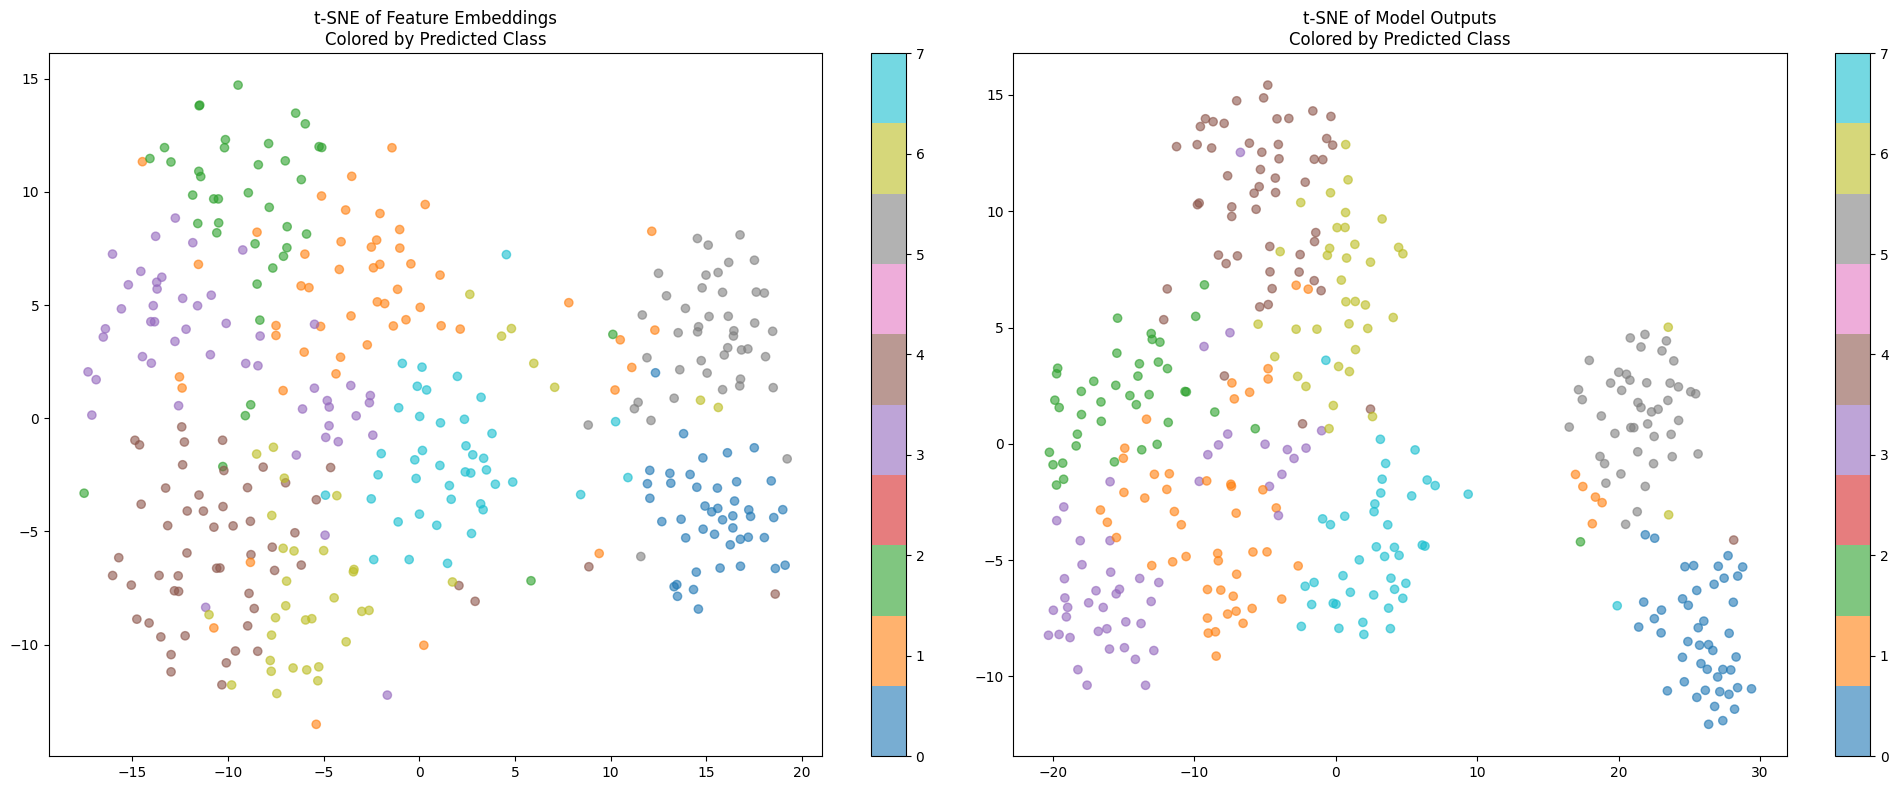

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def collect_embeddings_and_outputs(model, provider: PairsProvider):
    embeddings = []
    outputs = []
    pair_ids = provider.get_all_hash_ids()
    
    model.eval()
    with torch.no_grad():
        for pair_id in tqdm(pair_ids):
            image_path, _, _, _ = provider.load_pair(pair_id)
            image = provider.load_image(image_path)
            
            embedding = model.embed(image, use_representation=True)
            embeddings.append(embedding)
            
            transformed_image = model.transform(image)
            transformed_image = transformed_image.to(model.device)
            output = model(transformed_image.unsqueeze(0)).cpu().numpy()[0]
            outputs.append(output)
    
    return np.array(embeddings), np.array(outputs)

embeddings, outputs = collect_embeddings_and_outputs(model, provider)

predicted_classes = np.argmax(outputs, axis=1)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
outputs_2d = tsne.fit_transform(outputs)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=predicted_classes, 
                     cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE of Feature Embeddings\nColored by Predicted Class')

plt.subplot(1, 2, 2)
scatter = plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=predicted_classes, 
                     cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE of Model Outputs\nColored by Predicted Class')

plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

In [97]:
class CLIPImageEncoder(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        # Projection head from CLIP's 512 to final dimension
        self.projection = nn.Sequential(
            nn.Linear(512, projection_dim),
            nn.LayerNorm(projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x)
            image_features = image_features.float()
        return self.projection(image_features)

class EmotionEncoderWithProjection(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        self.base_encoder = EmotionModel(pretrained=False).to(device)
        self.base_encoder.load(MODEL_CHKPT)
        
        for param in self.base_encoder.parameters():
            param.requires_grad = False
        
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, projection_dim),
            nn.LayerNorm(projection_dim)
        )

    def forward(self, x):
        batch_embeddings = []
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
            # If batch dimension is present, process each image
            if len(x.shape) == 4:
                for img in x:
                    embedding = self.base_encoder.embed(img, use_representation=True)
                    batch_embeddings.append(embedding)
                embeddings = np.stack(batch_embeddings)
            else:
                embeddings = self.base_encoder.embed(x, use_representation=True)
                embeddings = np.expand_dims(embeddings, 0)
        
        embeddings = torch.from_numpy(embeddings).float().to(device)
        return self.projection_head(embeddings)


    
def calculate_cosine_similarity(image_embedding, emotion_embedding):
    image_embedding = F.normalize(image_embedding, p=2, dim=-1)
    emotion_embedding = F.normalize(emotion_embedding, p=2, dim=-1)
    return torch.mean(torch.cosine_similarity(image_embedding, emotion_embedding)).item()

In [98]:
provider = PairsProvider(storage_path=STORAGE_PATH)
_, preprocess = clip.load("ViT-B/32", device=device)

In [99]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, ids, provider, preprocess, emotion_model):
        self.ids = ids
        self.provider = provider
        self.preprocess = preprocess  # CLIP preprocessing for frames
        self.emotion_model = emotion_model
        self.emotion_model.eval()
        self.viz_transform = transforms.ToTensor()
        
        self.face_emotions = {}
        for id in tqdm(ids, desc="Computing face emotions"):
            face_path, _, _, _ = provider.load_pair(id)
            face_image = PairsProvider.load_image(face_path)
            face_image = Image.fromarray(face_image).convert('RGB')
            face_tensor = self.emotion_model.transform(face_image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                emotion_logits = self.emotion_model(face_tensor)
                emotion_pred = torch.argmax(emotion_logits).item()
                self.face_emotions[id] = emotion_pred

        self.total_frames = 0
        self.id_to_frame_range = {}
        start = 0
        for id in ids:
            _, _, _, video_path = provider.load_pair(id)
            frames = PairsProvider.get_video_frames(video_path)
            num_frames = len(frames)
            self.id_to_frame_range[id] = (start, start + num_frames)
            self.total_frames += num_frames
            start += num_frames

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx, normalize=True):
        for id, (start, end) in self.id_to_frame_range.items():
            if start <= idx < end:
                frame_idx = idx - start
                break
        
        face_image_path, _, _, video_path = self.provider.load_pair(id)
        frames = PairsProvider.get_video_frames(video_path)
        
        frame_pil = Image.fromarray(frames[frame_idx]).convert('RGB')
        face_pil = Image.fromarray(PairsProvider.load_image(face_image_path)).convert('RGB')
        
        if normalize:
            frame = self.preprocess(frame_pil)
            face = np.array(face_pil) 
        else:
            frame = self.viz_transform(frame_pil)
            face = self.viz_transform(face_pil)
        
        face_emotion = self.face_emotions[id]
        
        return frame, face, face_emotion
            
        

In [100]:
emotion_model = EmotionModel(pretrained=True).to(device)
model.load(MODEL_CHKPT)
emotion_model.eval()


EmotionModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

Starting ContrastiveDataset tests...


Computing face emotions: 100%|██████████| 8/8 [00:00<00:00, 103.91it/s]


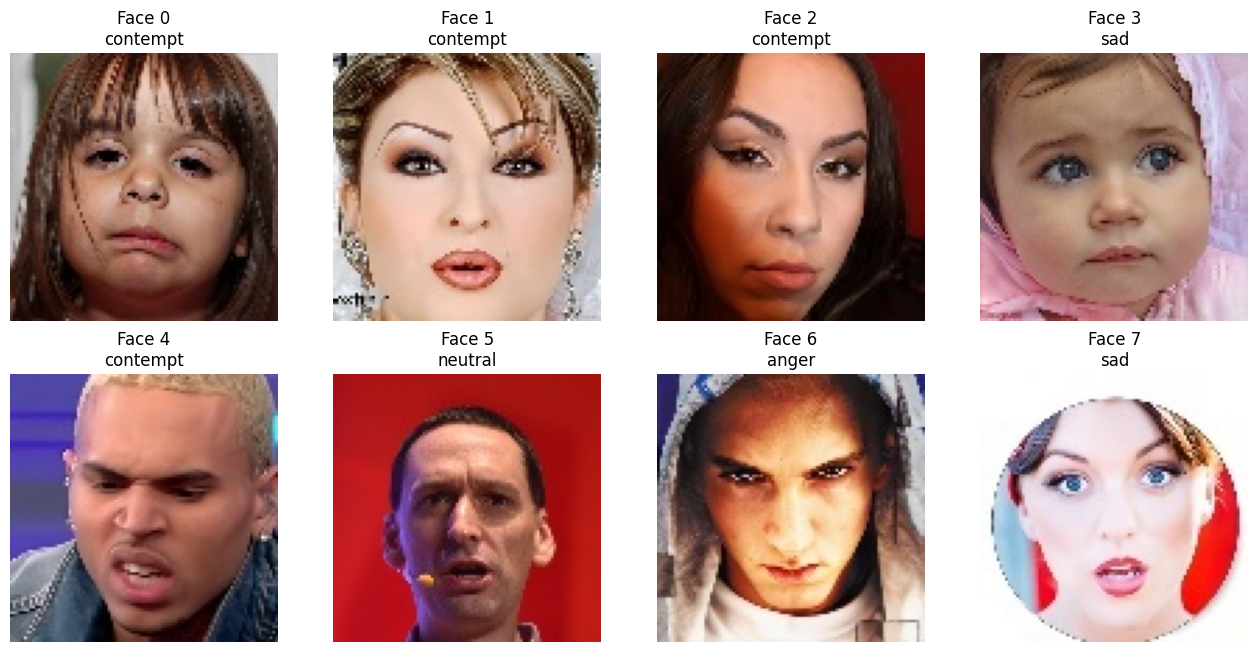

In [101]:
def test_contrastive_dataset():
    print("Starting ContrastiveDataset tests...")
    
    emotion_dict = {
        0: "happy",
        1: "sad",
        2: "anger",
        3: "disgust",
        4: "fear",
        5: "neutral",
        6: "surprise",
        7: "contempt",
    }
    
    dataset = ContrastiveDataset(
        ids=train_ids[:8],  
        provider=provider,
        preprocess=preprocess,
        emotion_model=emotion_model
    )
    
    plt.figure(figsize=(16, 16))

    ids = list(dataset.id_to_frame_range.keys())
    for i in range(min(16, len(ids))):
        start, _ = dataset.id_to_frame_range[ids[i]]
        frame, face, face_emotion = dataset.__getitem__(start, normalize=False)
        
        plt.subplot(4, 4, i+1)
        plt.imshow(face.permute(1, 2, 0)[:, :, [2,1,0]].cpu())
        plt.title(f'Face {i}\n{emotion_dict[face_emotion]}')
        plt.axis('off')
        
        
test_contrastive_dataset()

Starting ContrastiveDataset tests...


Computing face emotions: 100%|██████████| 2/2 [00:00<00:00, 77.98it/s]


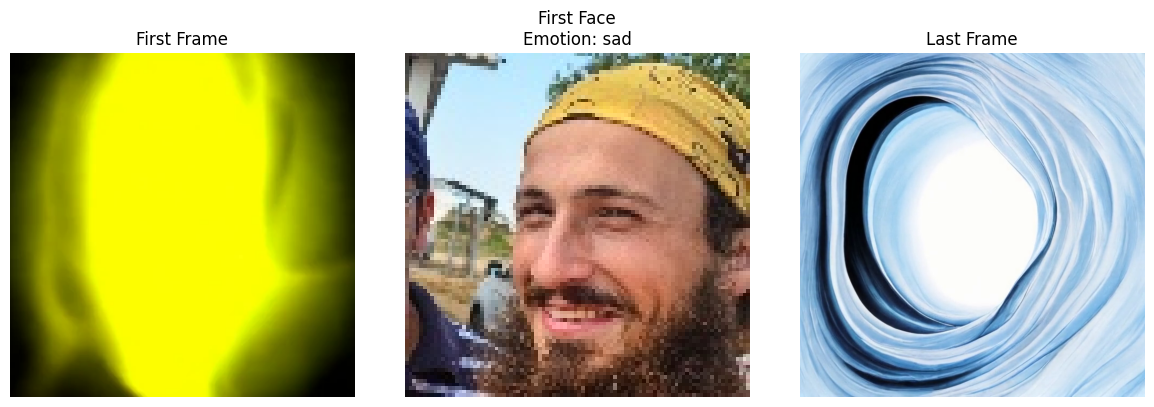


Test 1: Initialization
Total frames: 816
Frame ranges: {'PION323U27': (0, 408), 'NSJ62HGYV4': (408, 816)}
Pre-computed face emotions: {'PION323U27': 1, 'NSJ62HGYV4': 1}

Test 2: Length verification
Dataset length verified: 816

Test 3: Item retrieval
First item:
- Frame shape: torch.Size([3, 640, 640])
- Face shape: torch.Size([3, 96, 96])
- Face emotion: 1

Last item:
- Frame shape: torch.Size([3, 640, 640])
- Face shape: torch.Size([3, 96, 96])
- Face emotion: 1

Test 4: Batch loading
Batch shapes and types:
- Frames: torch.Size([4, 3, 224, 224])
- Faces: torch.Size([4, 96, 96, 3])
- Face emotions: torch.Size([4])

Test 5: Emotion consistency

All tests passed successfully!


In [102]:
def test_contrastive_dataset():
    
    emotion_dict = {
        0: "happy",
        1: "sad",
        2: "anger",
        3: "disgust",
        4: "fear",
        5: "neutral",
        6: "surprise",
        7: "contempt",
    }
    
    dataset = ContrastiveDataset(
        ids=train_ids[13:15],  
        provider=provider,
        preprocess=preprocess,
        emotion_model=emotion_model
    )
    
    plt.figure(figsize=(12, 4))
    index = 3
    
    frame, face, face_emotion = dataset.__getitem__(index, normalize=False)

    plt.subplot(1, 3, 1)
    plt.imshow(frame.permute(1, 2, 0)[:, :, [2,1,0]].cpu())
    plt.title(f'First Frame')
    plt.axis('off')

    # For face visualization
    plt.subplot(1, 3, 2)
    plt.imshow(face.permute(1, 2, 0)[:, :, [2,1,0]].cpu())
    plt.title(f'First Face\nEmotion: {emotion_dict[face_emotion]}')
    plt.axis('off')

    # Last frame
    frame, face, face_emotion = dataset.__getitem__(index*407, normalize=False)
    plt.subplot(1, 3, 3)
    plt.imshow(frame.permute(1, 2, 0)[:, :, [2,1,0]].cpu())
    plt.title(f'Last Frame')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nTest 1: Initialization")
    print(f"Total frames: {dataset.total_frames}")
    print(f"Frame ranges: {dataset.id_to_frame_range}")
    print(f"Pre-computed face emotions: {dataset.face_emotions}")
    assert len(dataset.face_emotions) == 2, "Should have emotions for 2 face images"
    
    # Test 2: Length verification
    print("\nTest 2: Length verification")
    expected_length = sum(end - start for start, end in dataset.id_to_frame_range.values())
    assert len(dataset) == expected_length, f"Length mismatch: got {len(dataset)}, expected {expected_length}"
    print(f"Dataset length verified: {len(dataset)}")
    
    # Test 3: Item retrieval
    print("\nTest 3: Item retrieval")
    
    # Test first frame
    frame, face, face_emotion = dataset.__getitem__(0, normalize=False)
    print(f"First item:")
    print(f"- Frame shape: {frame.shape}")
    print(f"- Face shape: {face.shape}")
    print(f"- Face emotion: {face_emotion}")
    assert isinstance(face_emotion, int), "Face emotion should be an integer"
    
    # Test last frame
    frame, face, face_emotion = dataset.__getitem__(len(dataset)-1, normalize=False)
    print(f"\nLast item:")
    print(f"- Frame shape: {frame.shape}")
    print(f"- Face shape: {face.shape}")
    print(f"- Face emotion: {face_emotion}")
    
    # Test 4: Batch loading
    print("\nTest 4: Batch loading")
    loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
    frames, faces, face_emotions = next(iter(loader))
    
    print("Batch shapes and types:")
    print(f"- Frames: {frames.shape}")
    print(f"- Faces: {faces.shape}")
    print(f"- Face emotions: {face_emotions.shape}")
    
    assert frames.shape[0] == faces.shape[0] == face_emotions.shape[0], \
        "Batch dimensions should match"
    
    # Test 5: Emotion consistency
    print("\nTest 5: Emotion consistency")
    # Check if face emotions are consistent for the same ID
    first_id = list(dataset.id_to_frame_range.keys())[0]
    start, end = dataset.id_to_frame_range[first_id]
    face_emotion_1 = dataset[start][2]  # Changed index from 3 to 2
    face_emotion_2 = dataset[start + 1][2]  # Changed index from 3 to 2
    assert face_emotion_1 == face_emotion_2, \
        "Face emotions should be consistent for frames from the same video"
    
    print("\nAll tests passed successfully!")

test_contrastive_dataset()

In [117]:
from aura.dataset import PairsProvider

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir='../logs/clip_experiment')

emotion_model.eval()
image_encoder = CLIPImageEncoder(projection_dim=128).to(device)
emotion_encoder = EmotionEncoderWithProjection(projection_dim=128).to(device)

optimizer = optim.AdamW([
    {'params': image_encoder.projection.parameters()},
    {'params': emotion_encoder.projection_head.parameters()}
], lr=1e-4, weight_decay=0.01)


/aul/homes/glucc002/miniconda3/envs/aura/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/aul/homes/glucc002/miniconda3/envs/aura/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [109]:
def emotion_aware_nce_loss(image_embeddings, emotion_embeddings, emotions, temperature=0.07):
    device = image_embeddings.device  
    
    image_embeddings = F.normalize(image_embeddings, dim=1)
    emotion_embeddings = F.normalize(emotion_embeddings, dim=1)
    
    similarity_matrix = torch.matmul(image_embeddings, emotion_embeddings.t()) / temperature
    
    positive_mask = (emotions.unsqueeze(1) == emotions.unsqueeze(0)).to(device)
    
    exp_sim = torch.exp(similarity_matrix)
    log_prob = torch.log(
        exp_sim / (exp_sim.sum(dim=1, keepdim=True) + 1e-7)
    )
    
    loss = -(positive_mask.float() * log_prob).sum(dim=1).mean()
    return loss

In [118]:
batch_size = 32
num_epochs = 10
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'


In [110]:
train_dataset = ContrastiveDataset(train_ids, provider, preprocess, emotion_model)
val_dataset = ContrastiveDataset(val_ids, provider, preprocess, emotion_model)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


Computing face emotions: 100%|██████████| 73/73 [00:00<00:00, 107.84it/s]


In [ ]:


for epoch in range(num_epochs):
    image_encoder.train()
    emotion_encoder.train()
    
    train_loss = 0.0
    train_similarity = 0.0
    
    for frames, face_images, face_emotions in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        frames = frames.to(device)
        face_images = face_images.to(device)
        face_emotions = face_emotions.to(device)
        
        optimizer.zero_grad()
        
        image_embeddings = image_encoder(frames)
        emotion_embeddings = emotion_encoder(face_images)
        
        loss = emotion_aware_nce_loss(
            image_embeddings, 
            emotion_embeddings, 
            face_emotions,
            temperature=0.07
        )
        similarity = calculate_cosine_similarity(image_embeddings, emotion_embeddings)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_similarity += similarity

    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_similarity = train_similarity / len(train_loader)
    
    image_encoder.eval()
    emotion_encoder.eval()
    val_loss = 0.0
    val_similarity = 0.0
    
    with torch.no_grad():
        for frames, face_images, face_emotions in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):            
            frames = frames.to(device)
            face_images = face_images.to(device)
            
            image_embeddings = image_encoder(frames)
            emotion_embeddings = emotion_encoder(face_images)
            
            loss = emotion_aware_nce_loss(
                image_embeddings, 
                emotion_embeddings, 
                face_emotions,
                temperature=0.07
            )
            similarity = calculate_cosine_similarity(image_embeddings, emotion_embeddings)
            
            val_loss += loss.item()
            val_similarity += similarity
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_similarity = val_similarity / len(val_loader)
    
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Similarity/Train', avg_train_similarity, epoch)
    writer.add_scalar('Similarity/Validation', avg_val_similarity, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Similarity: {avg_train_similarity:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Similarity: {avg_val_similarity:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'image_encoder': image_encoder.state_dict(),
            'emotion_encoder': emotion_encoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': best_val_loss
        }, best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

writer.close()

# Load best model
checkpoint = torch.load(best_model_path)
image_encoder.load_state_dict(checkpoint['image_encoder'])
emotion_encoder.load_state_dict(checkpoint['emotion_encoder'])


Running Inference: 100%|██████████| 363/363 [00:13<00:00, 27.39it/s]


Recall@1: 0.0000
Recall@5: 0.0055
Recall@10: 0.0275
Recall@25: 0.0634
Recall@30: 0.0689
Recall@45: 0.0992
Recall@60: 0.1543
Recall@100: 0.2507


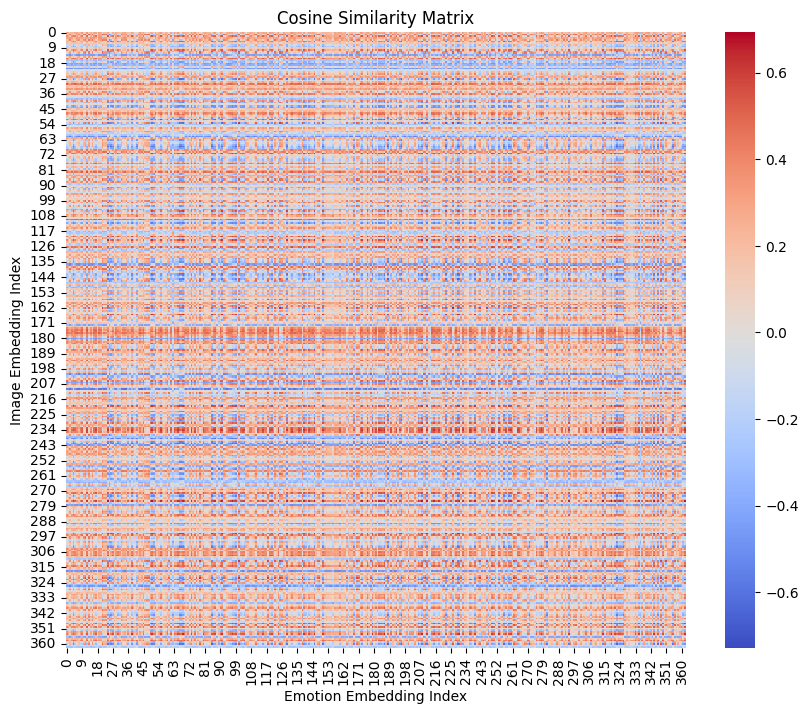

In [138]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from aura.dataset.clip_provider import PairsProvider

def compute_cosine_similarity(image_embeddings, emotion_embeddings):
    image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
    emotion_embeddings = F.normalize(emotion_embeddings, p=2, dim=1)
    similarity_matrix = torch.mm(image_embeddings, emotion_embeddings.t())
    return similarity_matrix

def recall_at_k(similarity_matrix, true_labels, k=1):
    num_images = similarity_matrix.size(0)
    correct = 0

    for i in range(num_images):
        top_k_indices = similarity_matrix[i].topk(k, largest=True).indices
        
        if true_labels[i] in top_k_indices:
            correct += 1

    return correct / num_images

all_image_embeddings = []
all_emotion_embeddings = []
true_labels = [] 

batch_size = 32 
batch_frames = []
batch_face_images = []

for id in tqdm(provider.get_all_hash_ids(), desc="Running Inference"):
    face_image_path, _, embedding_path, video_path = provider.load_pair(id)
    face_image = PairsProvider.load_image(face_image_path)
    frame = provider.get_first_video_frame(video_path)

    if isinstance(face_image, np.ndarray):
        face_image = Image.fromarray(face_image)
    if isinstance(frame, np.ndarray):
        frame = Image.fromarray(frame)

    frame = preprocess(frame).unsqueeze(0).to(device)  
    face_image = emotion_model.transform(face_image).unsqueeze(0).to(device)  
    batch_frames.append(frame)
    batch_face_images.append(face_image)

    if len(batch_frames) == batch_size:
        batch_frames_tensor = torch.cat(batch_frames, dim=0)
        batch_face_images_tensor = torch.cat(batch_face_images, dim=0)
        batch_face_images_tensor = batch_face_images_tensor.permute(0, 3, 2, 1).to(device)

        image_embeddings = image_encoder(batch_frames_tensor)
        emotion_embeddings = emotion_encoder(batch_face_images_tensor)

        all_image_embeddings.append(image_embeddings)
        all_emotion_embeddings.append(emotion_embeddings)

        true_labels.extend(range(batch_size))  

        batch_frames = []
        batch_face_images = []

if len(batch_frames) > 0:
    batch_frames_tensor = torch.cat(batch_frames, dim=0)
    batch_face_images_tensor = torch.cat(batch_face_images, dim=0)
    batch_face_images_tensor = batch_face_images_tensor.permute(0, 3, 2, 1).to(device)

    image_embeddings = image_encoder(batch_frames_tensor)
    emotion_embeddings = emotion_encoder(batch_face_images_tensor)

    all_image_embeddings.append(image_embeddings)
    all_emotion_embeddings.append(emotion_embeddings)

    true_labels.extend(range(len(batch_frames)))

all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
all_emotion_embeddings = torch.cat(all_emotion_embeddings, dim=0)

similarity_matrix = compute_cosine_similarity(all_image_embeddings, all_emotion_embeddings)

for k in [1, 5, 10, 25, 30, 45, 60, 100]:
    recall_score = recall_at_k(similarity_matrix, torch.tensor(true_labels), k=k)

    print(f"Recall@{k}: {recall_score:.4f}")

plt.figure(figsize=(10, 8))
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()
sns.heatmap(similarity_matrix_np, cmap='coolwarm', cbar=True)
plt.title("Cosine Similarity Matrix")
plt.xlabel("Emotion Embedding Index")
plt.ylabel("Image Embedding Index")
plt.show()
